# WTTE-pipeline : data-munging template


Simple pipeline. Take by-timestamp records-data, aggregate over larger timeinterval (discretize) and reshape to tensor. 


# Example pipe

FLOW :
1. Munge df
    - want id,time to be unique
    - want to know start and end of sequence
    - want to have reasonable time-resolution (ex aggregate over days)
2. Padd with zeros for days between observations
3. Embed in fix-format tensor via rightpadding
4. Calculate censoring indicators and time to event
5. Train, Predict, Enjoy


### Meta-example: Tensorflow commit data
```
    git clone https://github.com/tensorflow/tensorflow.git
    cd tensorflow
    FILENAME="tensorflow.csv"

    echo commit,author_name,time_sec,subject,files_changed,lines_inserted,lines_deleted>../$FILENAME;

    git log --oneline --pretty="_Z_Z_Z_%h_Y_Y_\"%an\"_Y_Y_%at_Y_Y_\"%<(79,trunc)%f\"_Y_Y__X_X_"  --stat    \
        | grep -v \| \
        | sed -E 's/@//g' \
        | sed -E 's/_Z_Z_Z_/@/g' \
        |  tr "\n" " "   \
        |  tr "@" "\n" |sed -E 's/,//g'  \
        | sed -E 's/_Y_Y_/, /g' \
        | sed -E 's/(changed [0-9].*\+\))/,\1,/'  \
        | sed -E 's/(changed [0-9]* deleti.*-\)) /,,\1/' \
        | sed -E 's/insertion.*\+\)//g' \
        | sed -E 's/deletion.*\-\)//g' \
        | sed -E 's/,changed/,/' \
        | sed -E 's/files? ,/,/g'  \
        | sed -E 's/_X_X_ $/,,/g'  \
        | sed -E 's/_X_X_//g' \
        | sed -E 's/ +,/,/g' \
        | sed -E 's/, +/,/g'>>../$FILENAME;
```     

For details about WTTE-RNN, check out

https://ragulpr.github.io/

https://github.com/ragulpr/wtte-rnn

https://github.com/ragulpr/wtte-rnn

http://wtte-rnn.readthedocs.io/en/develop/

Written by Egil Martinsson

MIT license

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import xrange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte
import wtte.transforms as tr

from wtte.pipelines import data_pipeline
from wtte.plots.misc import timeline_aggregate_plot,timeline_plot

pd.options.display.max_rows = 10
from IPython import display

print('np.__version__',np.__version__)
print('pd.__version__',pd.__version__)
import matplotlib
print('matplotlib.__version__',matplotlib.__version__)
np.random.seed(1)


np.__version__ 1.14.0
pd.__version__ 0.22.0
matplotlib.__version__ 2.1.0


b'Skipping line 840: expected 7 fields, saw 9\nSkipping line 1210: expected 7 fields, saw 9\nSkipping line 1414: expected 7 fields, saw 9\nSkipping line 5570: expected 7 fields, saw 9\nSkipping line 6017: expected 7 fields, saw 9\nSkipping line 6287: expected 7 fields, saw 9\nSkipping line 6290: expected 7 fields, saw 9\nSkipping line 7268: expected 7 fields, saw 9\nSkipping line 9960: expected 7 fields, saw 9\nSkipping line 10063: expected 7 fields, saw 9\nSkipping line 13076: expected 7 fields, saw 9\nSkipping line 14642: expected 7 fields, saw 9\n'


['commit' 'author_name' 'time_sec' 'subject' 'files_changed'
 'lines_inserted' 'lines_deleted']


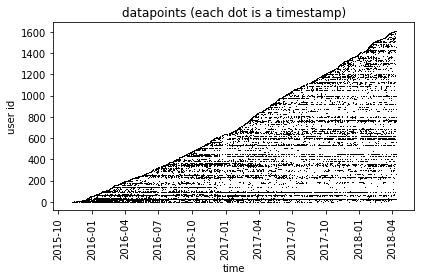

,commit,author_name,time_int,subject,files_changed,lines_inserted,lines_deleted,id,n_commits
31314,f41959c,Manjunath Kudlur,1446856078,TensorFlow-Initial-commit-of-TensorFlow-librar...,1900.0,391534.0,0.0,1,1
31313,cd9e60c,Manjunath Kudlur,1446863831,TensorFlow-Upstream-latest-changes-to-Git ...,72.0,1289.0,958.0,1,1
31307,71842da,Manjunath Kudlur,1447019816,TensorFlow-Upstream-latest-changes-to-git ...,14.0,110.0,110.0,1,1
31306,1d3874f,Manjunath Kudlur,1447024477,TensorFlow-Upstream-changes-to-git ...,22.0,430.0,405.0,1,1
31305,b2dc60e,Manjunath Kudlur,1447033308,TensorFlow-Upstream-changes-to-git ...,34.0,398.0,314.0,1,1
...,...,...,...,...,...,...,...,...,...
43,7f2d9ad,Scott Zhu,1523319957,Merge-commit-for-internal-changes ...,0.0,0.0,0.0,1607,1
12,2fe6726,Scott Zhu,1523382917,Merge-commit-for-internal-changes ...,0.0,0.0,0.0,1607,1
28,3e0fd55,Qianli Scott Zhu,1523334315,Merge-pull-request-18366-from-qlzh727-branch_1...,0.0,0.0,0.0,1608,1
9,ac027cd,Qianli Scott Zhu,1523389716,Merge-pull-request-18388-from-qlzh727-branch_1...,0.0,0.0,0.0,1608,1


In [2]:

path = "~/Prylar/clones/logs/"
# filename = "amazon-dsstne.csv"
# filename = "caffe.csv"
# filename = "CNTK.csv"
# filename = "convnetjs.csv"
# filename = "deeplearning4j.csv"
# filename = "h2o-3.csv"
# filename = "incubator-singa.csv"
# filename = "keras.csv"
# filename = "mxnet.csv"
# filename = "Paddle.csv"
# filename = "Theano.csv"
# filename = "torch7.csv"
# filename = "veles.csv"
# filename = "linux.csv"
filename = "tensorflow.csv"

df = pd.read_csv(path+filename,error_bad_lines=False,low_memory=False)

print(df.columns.values)
df.fillna(0,inplace=True)

df.rename(columns={"time_sec": "time_int"},inplace=True)
## For transformation df->tensor
id_col='id'
abs_time_col='time_int'
# Put the column indicating 'events' first!
feature_cols= ["n_commits",'files_changed','lines_inserted','lines_deleted']
# feature_cols= ["n_commits"]
constant_cols = []
mean_cols = []

infer_seq_endtime=True
time_sec_interval=60*60*24
timestep_aggregation_dict=dict.fromkeys(feature_cols, "sum")
drop_last_timestep=True


## Create a new sequence-key based on time of first event.
df[id_col] = df.groupby(['author_name'], group_keys=False).\
               apply(lambda g: g.time_int.min().\
               astype(str)+g.author_name.astype(str)).\
               rank(method='dense').astype(int)

df.sort_values([id_col,'time_int'],inplace=True)

df['n_commits'] = 1
# Last observed eventtime is almost always erronous. Ex dates in the future. 
df = df.loc[df['time_int'] < df['time_int'].max()]

plt.scatter(pd.to_datetime(df.time_int,unit='s').values, df.id.values, marker="s", color="black", s=1, linewidths=0,)
# just set x to df.time_int if error "TypeError: invalid type promotion", you're using old matplotlib version.
plt.xticks(rotation='vertical')
plt.title('datapoints (each dot is a timestamp)')
plt.xlabel('time')
plt.ylabel('user id')
plt.tight_layout()
plt.show()

df

In [3]:
import re
# Aggregates by timestep using sum by default. 
# `constant_cols` and `mean_cols` are aggregated using mean
timestep_aggregation_dict = dict.fromkeys(feature_cols, "sum")
for key in timestep_aggregation_dict:
    for query in list(set().union(constant_cols,mean_cols)):
        if re.match(query+'($|_)', key): # binary cols are formatted as `col_level`
            timestep_aggregation_dict[key] = 'mean'
print('how features will be aggregated each day:')
print(timestep_aggregation_dict)

how features will be aggregated each day:
{'n_commits': 'sum', 'files_changed': 'sum', 'lines_inserted': 'sum', 'lines_deleted': 'sum'}


## Dataframe to tensor

    1. Lower the resolution of the (int) `abs_time_col` ex from epoch sec to epoch day by aggregating\
      each column using `timestep_aggregation_dict`.

    2. Padds out with zeros between timesteps and fills with value of `constant_cols`.

    3. Infers where the last 'non-event' was, i.e the day that we made the query. This is the time of censoring.

If you think this is too much magic, look out for the next example notebook which will break up the steps.

In [4]:
discrete_time=True
pad_between_steps=True

x, padded_t, seq_ids, df_tmp = \
    data_pipeline(df,
                  id_col=id_col,
                  abs_time_col=abs_time_col,
                  column_names=feature_cols,
                  constant_cols = constant_cols,
                  discrete_time=discrete_time,
                  pad_between_steps=pad_between_steps,
                  infer_seq_endtime=infer_seq_endtime,
                  time_sec_interval=time_sec_interval,
                  timestep_aggregation_dict=timestep_aggregation_dict,
                  drop_last_timestep=drop_last_timestep
                  )
print(x.shape)
df_tmp


(1608, 886, 4)


,id,time_int,n_commits,files_changed,lines_inserted,lines_deleted,t_elapsed
0,1,1446854400,2.0,1972.0,392823.0,958.0,0
1,1,1446940800,2.0,36.0,540.0,515.0,1
2,1,1447027200,7.0,68.0,1888.0,1755.0,2
3,1,1447977600,1.0,1271.0,18402.0,1067.0,13
4,1,1448409600,3.0,322.0,5183.0,2888.0,18
...,...,...,...,...,...,...,...
15050,1605,1523318400,0.0,0.0,0.0,0.0,3
15051,1606,1523232000,1.0,1.0,0.0,2.0,0
15052,1606,1523318400,0.0,0.0,0.0,0.0,1
15053,1607,1523318400,2.0,0.0,0.0,0.0,0


### The first feature in `x` is the event-indicator

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


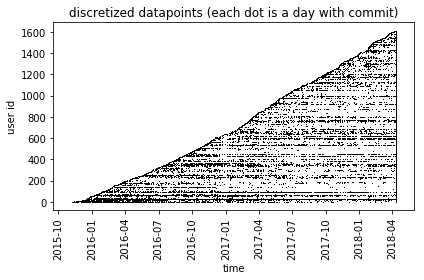

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


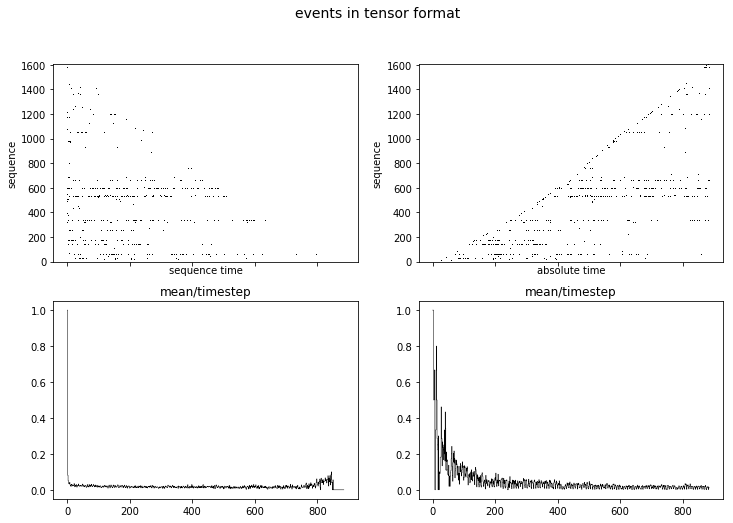

In [5]:
# We assume the first column is the event-indicator:
events = (np.copy(x[:,:,0])>0).astype(float)
events[np.isnan(x[:,:,0])] = np.nan

plt.scatter(pd.to_datetime(df_tmp['time_int'],unit='s').values, df_tmp['id'].values, marker="s", color="black", s=1, linewidths=0,)
plt.xticks(rotation='vertical')
plt.title('discretized datapoints (each dot is a day with commit)')
plt.xlabel('time')
plt.ylabel('user id')
plt.tight_layout()
plt.show()

timeline_aggregate_plot(events,"events in tensor format",cmap="Greys")
plt.show()

# It may seem like the tensor-format is more sparse, but it's actually the same number of events;
assert(np.nansum(df_tmp.n_commits.values>0)==np.nansum(events))

### Example of tensor-feature engineering - global features

- Simply add the mean events per day time series to every timestep where it was known in realtime. (I.e the 'mean/timestep'-series above)

In [6]:
# Add a global feature "mean (number of events) per user today"
add_global_feature = True
if add_global_feature:
    padded = tr.right_pad_to_left_pad(x[:,:,0])
    x_global = np.nanmean(padded,0)
    x_global = np.expand_dims(x_global,0)
    x_global = padded*0+x_global

    x_global =  tr.left_pad_to_right_pad(x_global)
    x = np.concatenate([x,np.expand_dims(x_global,-1)],-1)
    
    feature_cols.append('mean_commits_yesterday')
    del padded,x_global

# If we have count-based (positive) features we can log-squash outliers
if np.nanmin(x)>=0:
    print('Using Log')
    x = np.log(x+1)


Using Log


## Format tensor for training
* calculate tte-values
* Split into train/test. Some alternatives:
* **Hide the truth from the model** (disalign features and target). 
    - Think *'todays prediction about today and tomorrow is from what happened yesterday'*
* normalize (using training data)

In [7]:
def drop_n_last_timesteps(padded,n_timesteps_to_drop,remove_empty_seqs = True):
    # brutal method: simply right align all tensors and simply cut off the last n_timesteps_to_drop
    n_timesteps = x.shape[1]
    padded      = tr.left_pad_to_right_pad(tr.right_pad_to_left_pad(padded)[:,:(n_timesteps-n_timesteps_to_drop)])
    
    if remove_empty_seqs:
        seq_lengths = tr.get_padded_seq_lengths(padded)
        padded = padded[seq_lengths>0]
    return padded
    
def prep_tensors(x,events):
    # 0. calculate time to event and censoring indicators.
    y  = np.ones([events.shape[0],events.shape[1],2])
    y[:,:,0] = tr.padded_events_to_tte(np.squeeze(events),discrete_time=True)
    y[:,:,1] = tr.padded_events_to_not_censored(np.squeeze(events),discrete_time=True)

    # 1. Disalign features and targets otherwise truth is leaked.
    # 2. drop first timestep (that we now dont have features for)
    # 3. nan-mask the last timestep of features. (that we now don't have targets for)
    events = events[:,1:,]
    y  = y[:,1:]
    x  = np.roll(x, shift=1, axis=1)[:,1:,]
    x  = x + 0*np.expand_dims(events,-1)
    return x,y,events

n_timesteps = x.shape[1]
n_features = x.shape[2]

## Hide frac_timesteps_to_cut of the last timesteps and keep them for testing
frac_timesteps_to_cut = 0.30
n_testing_timesteps = np.floor(n_timesteps*frac_timesteps_to_cut).astype(int)

x_train      = drop_n_last_timesteps(x,n_testing_timesteps)
events_train = drop_n_last_timesteps(events,n_testing_timesteps)

# Do the necessary preparations of the tensors.
x_train,y_train,events_train = prep_tensors(x_train,events_train)
x,y,events    = prep_tensors(x,events)

# Normalize
x_train, means, stds = tr.normalize_padded(x_train,means=None,stds=None,only_nonzero=True)
x, _, _ = tr.normalize_padded(x,means=means,stds=stds,only_nonzero=True)

seq_lengths = np.count_nonzero(~np.isnan(events), axis=1)
seq_lengths_train = np.count_nonzero(~np.isnan(events_train), axis=1)

# Used for initialization of alpha-bias:
tte_mean_train = np.nanmean(y_train[:,:,0])
mean_u = np.nanmean(y_train[:,:,1])

print('events',events.shape,events.dtype)
print('x min max ',np.nanmin(x),np.nanmax(x))
print('x',x.shape,x.dtype)
print('y',y.shape,y.dtype)
print('x_train',x_train.shape,x_train.dtype)
print('y_train',y_train.shape,y_train.dtype)
print('tte_mean_train: ', tte_mean_train)
print('mean uncensored train: ', np.nanmean(y_train[:,:,1]))

print('x_train size',x_train.nbytes*1e-6,' mb')

events (1608, 885) float64
x min max  -1.3714310063605963 28.27172280315575
x (1608, 885, 5) float64
y (1608, 885, 2) float64
x_train (1071, 620, 5) float64
y_train (1071, 620, 2) float64
tte_mean_train:  146.22923210722874
mean uncensored train:  0.2265752630412169
x_train size 26.5608  mb


## Visualize tensor data

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


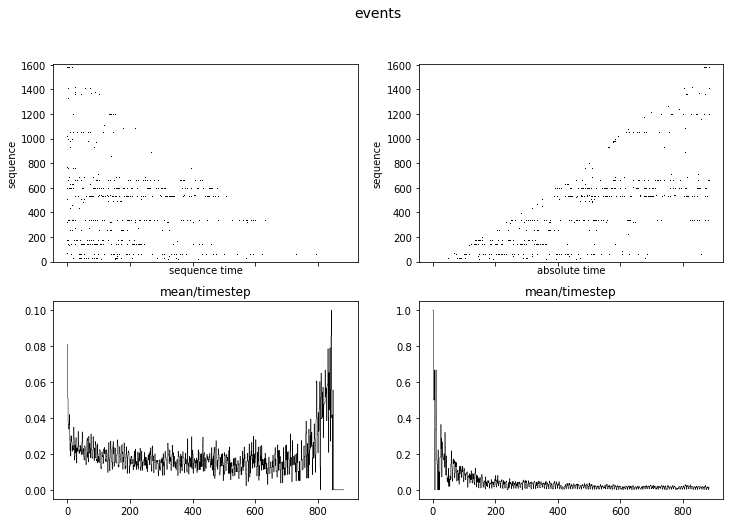

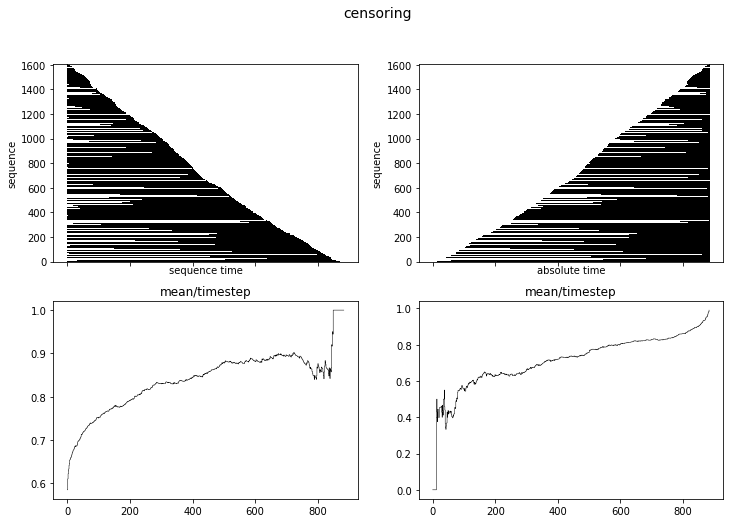

############## TRAINING SET


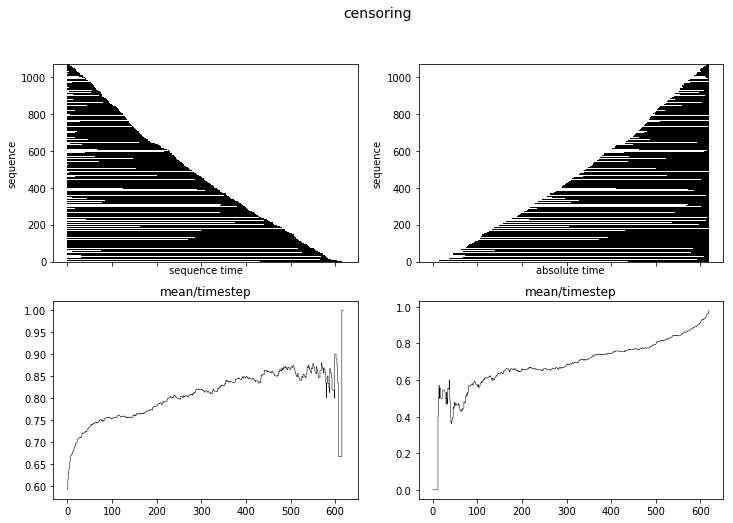

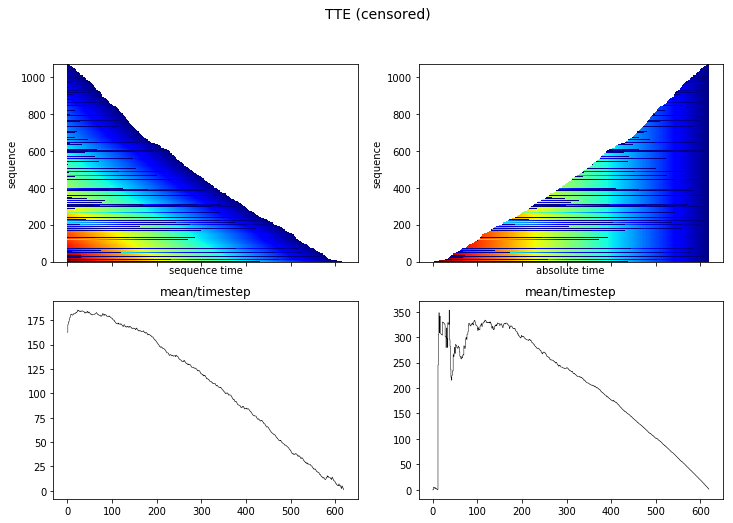

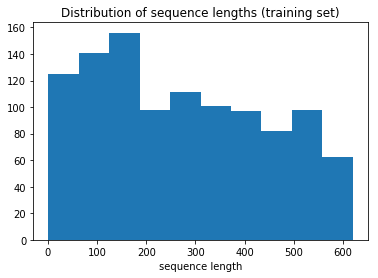

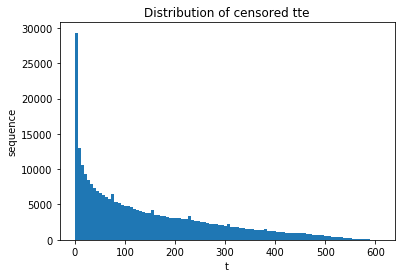

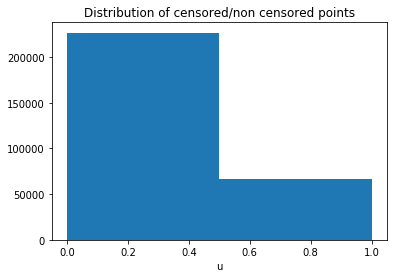

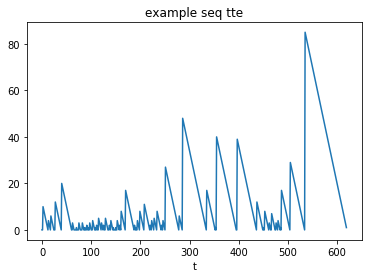

########## features


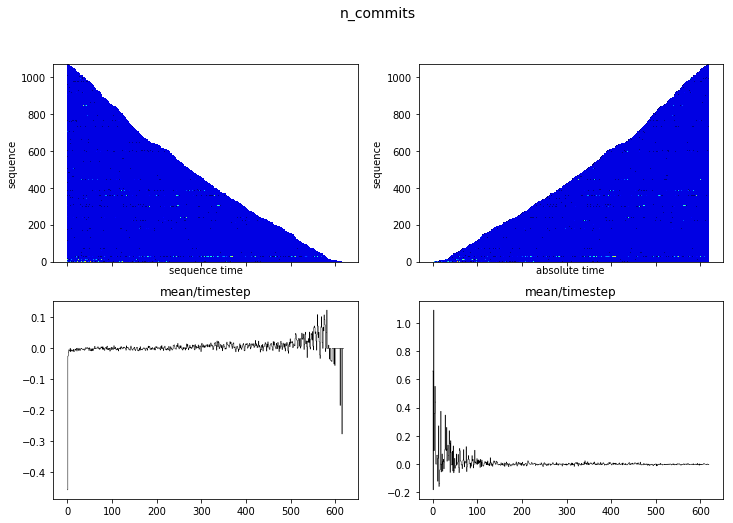

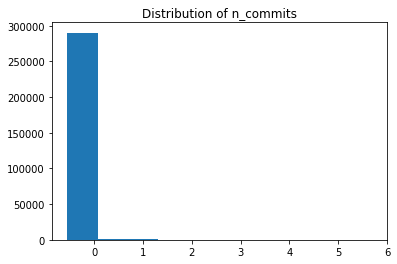

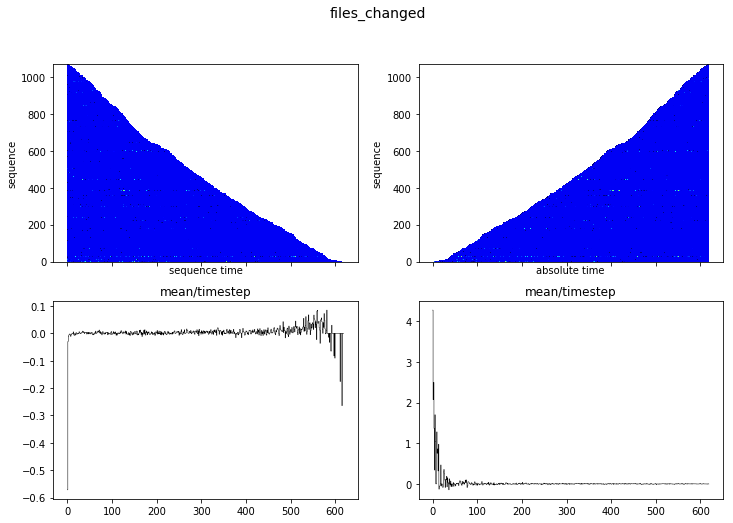

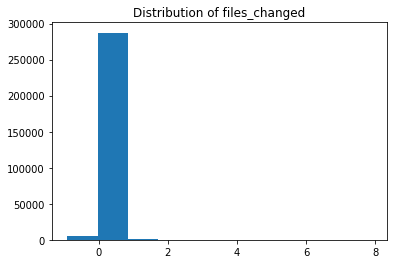

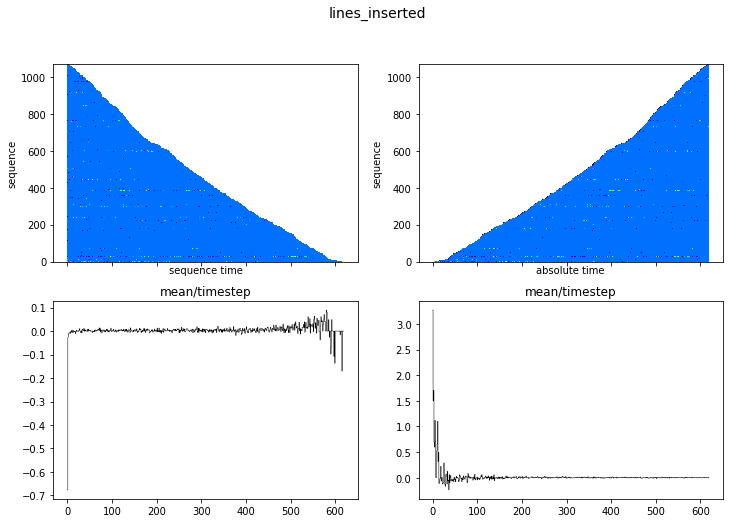

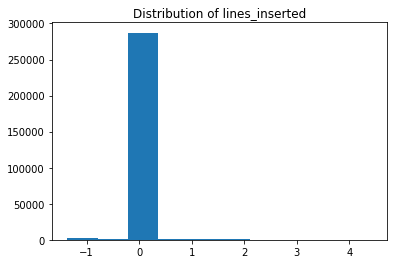

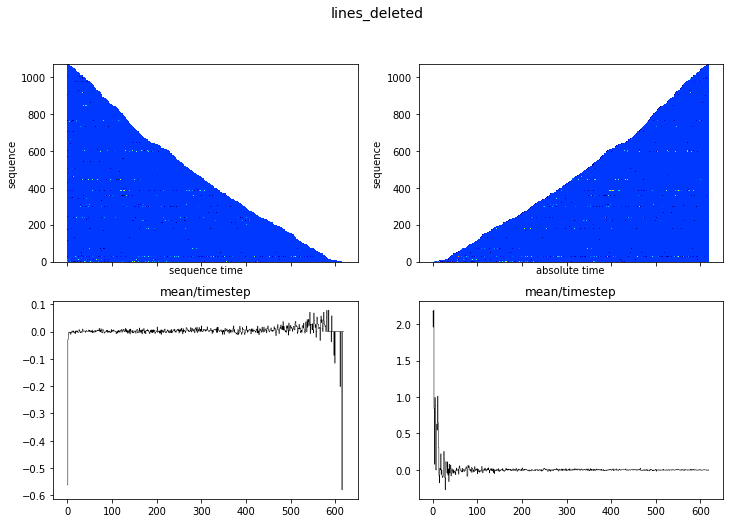

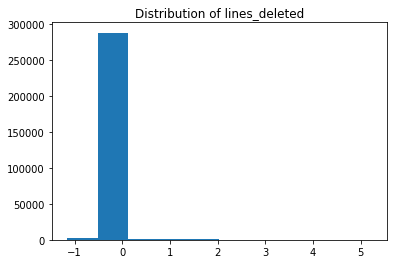

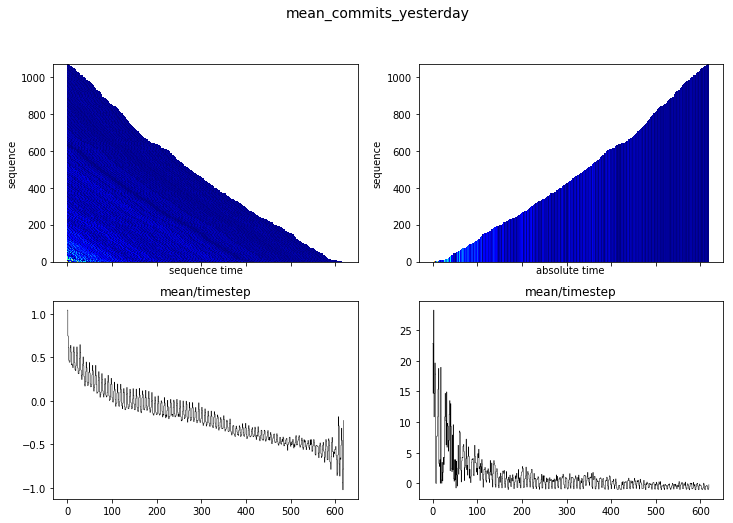

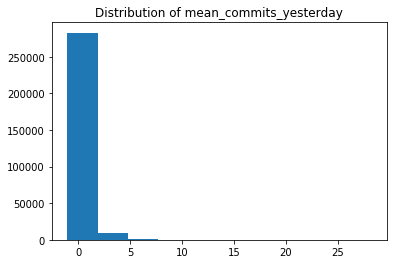

########## 


In [8]:
# def timeline_plot(padded,title='',cmap=None,plot=True,fig=None,ax=None):
#     if fig is None or ax is None:
#         fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(12,4))
    
#     ax[0].imshow(padded,interpolation='none', aspect='auto',cmap=cmap,origin='lower')    
#     ax[0].set_ylabel('sequence');
#     ax[0].set_xlabel('sequence time');
        
#     im = ax[1].imshow(tr.right_pad_to_left_pad(padded),interpolation='none', aspect='auto',cmap=cmap,origin='lower')  
#     ax[1].set_ylabel('sequence');
#     ax[1].set_xlabel('absolute time'); #(Assuming sequences end today)
    
#     fig.suptitle(title,fontsize=14)
#     if plot:
#         fig.show()
#         return None,None
#     else:
#         return fig,ax

# def timeline_aggregate_plot(padded,title='',cmap=None,plot=True):
#     fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=False,figsize=(12,8))
    
#     fig,ax[0] = timeline_plot(padded,title,cmap=cmap,plot=False,fig=fig,ax=ax[0])
    
#     ax[1,0].plot(np.nanmean(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
#     ax[1,0].set_title('mean/timestep')
#     padded = tr.right_pad_to_left_pad(padded)
#     ax[1,1].plot(np.nanmean(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
#     ax[1,1].set_title('mean/timestep')

#     fig.suptitle(title,fontsize=14)
#     if plot:
#         fig.show()
#         return None,None
#     else:
#         return fig,ax
    
timeline_aggregate_plot(events,"events",cmap="Greys")
plt.show()

timeline_aggregate_plot(1-y[:,:,1],"censoring",cmap="Greys")
plt.show()

print('############## TRAINING SET')
######
timeline_aggregate_plot(1-y_train[:,:,1],'censoring',cmap='Greys')
plt.show()
timeline_aggregate_plot(y_train[:,:,0],'TTE (censored)',cmap='jet')
plt.show()

train_mask = (False==np.isnan(y_train[:,:,0]))

plt.hist(seq_lengths_train)
plt.title('Distribution of sequence lengths (training set)')
plt.xlabel('sequence length')
plt.show()

plt.hist(y_train[:,:,0][train_mask].flatten(),100)
plt.title('Distribution of censored tte')
plt.ylabel('sequence')
plt.xlabel('t')
plt.show()

plt.hist(y_train[:,:,1][train_mask].flatten(),2)
plt.title('Distribution of censored/non censored points')
plt.xlabel("u")
plt.show()

plt.plot(y_train[0,:,0])
plt.title('example seq tte')
plt.xlabel('t')
plt.show()

print('########## features')
for f in xrange(x_train.shape[2]):
    try:
        feature_name = feature_cols[f]
    except:
        feature_name = '???'
        
    timeline_aggregate_plot(x_train[:,:,f],feature_name,cmap = 'jet')
    plt.show()
    tmp = x_train[:,:,f].flatten()
    plt.hist(tmp[False==np.isnan(tmp)],10)
    plt.title('Distribution of '+feature_name)
    plt.show()
print('########## ')
del tmp,train_mask


## Masks, weights and validation set

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


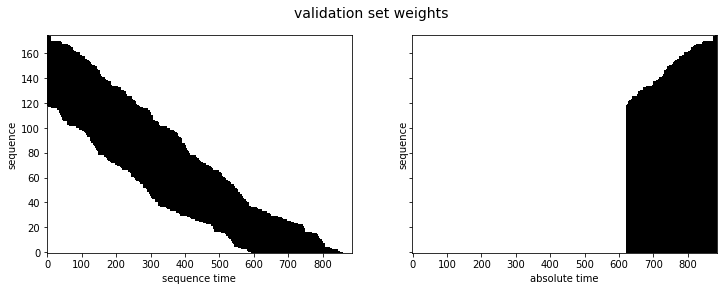

init_alpha:  647.5934848158339 mean uncensored train:  0.2265752630412169


In [9]:
def nanmask_to_keras_mask(x,y,mask_value,tte_mask):
    """nanmask to keras mask.
        :param float mask_value: Use some improbable telltale value 
                                (but not nan-causing)
        :param float tte_mask: something that wont NaN the loss-function
    """
    # Use some improbable telltale value (but not nan-causing)
    x[:,:,:][np.isnan(x)] = mask_value
    y[:,:,0][np.isnan(y[:,:,0])] = tte_mask
    y[:,:,1][np.isnan(y[:,:,1])] = 0.5
    sample_weights = (x[:,:,0]!=mask_value)*1.
    return x,y,sample_weights

mask_value = -1.3371337 

x_train,y_train,sample_weights_train = nanmask_to_keras_mask(x_train,y_train,mask_value,tte_mean_train)

# Pick 10% of the sequences beyond the boundary for validation during training (testing.)
valid_indx = np.where(np.random.sample(len(y))<0.1)
x_valid = x[valid_indx].copy()
y_valid = y[valid_indx].copy()
padded = np.copy(y_valid[:,:,0])

x_valid,y_valid,sample_weights_valid = nanmask_to_keras_mask(x_valid,y_valid,mask_value,tte_mean_train)

# Set weights to 0s except the non-nan last timesteps not in training
n_timesteps_to_hide = x_valid.shape[1]-x_train.shape[1]
padded[~np.isnan(padded)] = 1.
padded = tr.right_pad_to_left_pad(padded)
padded[:,:-n_timesteps_to_hide] = padded[:,:-n_timesteps_to_hide]*0
padded = tr.left_pad_to_right_pad(padded)
timeline_plot(padded,'validation set weights','Greys')

padded[np.isnan(padded)] = 0
sample_weights_valid = np.copy(padded)
plt.show()
del padded,valid_indx



# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)


In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte
import wtte.transforms as tr

from wtte.pipelines import data_pipeline
import wtte.tte_util as tte
import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

pd.options.display.max_rows = 20
from IPython import display

import keras.backend as K
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Masking
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed
from keras.layers.normalization import BatchNormalization

from keras import regularizers
from keras import callbacks
from keras.optimizers import RMSprop,adam
from keras.models import load_model

import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

import keras
print('keras.__version__',keras.__version__)
try:
    import theano
    print('theano.__version__',theano.__version__)
except:
    pass

def plot_twinaxis(x,y1,y2,xlabel,ylabel1,ylabel2):
    ##### Parameters
    # Create axes
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, y1, color='b')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1)

    ax2.plot(x, y2, color='r')
    ax2.set_ylabel(ylabel2)

    # Change color of each axis
    def color_y_axis(ax, color):
        """Color your axes."""
        for t in ax.get_yticklabels():
            t.set_color(color)
        return None
    color_y_axis(ax1, 'b')
    color_y_axis(ax2, 'r')
    plt.show()
    

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


keras.__version__ 2.1.2
theano.__version__ 1.0.1+unknown


In [11]:
# from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM
K.set_epsilon(1e-8)
np.random.seed(1)

## Callbacks
checkpointer = callbacks.ModelCheckpoint('./model_checkpoint.h5', 
                          monitor='loss', 
                          verbose=1, 
                          save_best_only=True, 
                          save_weights_only=True, 
                          mode='auto', period=50)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
                                        factor  =0.5, 
                                        patience=10, 
                                        verbose=1, 
                                        mode='min', 
                                        epsilon=0.0001, 
                                        cooldown=5, 
                                        min_lr=1e-5)

nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch =False,per_epoch= True)
n_features = x_train.shape[-1]

## Base model
model = Sequential()
model.add(Masking(mask_value=mask_value,input_shape=(None, n_features)))
model.add(TimeDistributed(Dense(5,activation='tanh')))

model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))
model.add(GRU(10,activation='tanh',return_sequences=True,recurrent_dropout=0.1,unroll=False))

model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))
model.add(TimeDistributed(Dense(10,activation='tanh')))

## Wtte-RNN part
model.add(TimeDistributed(Dense(2)))
model.add(Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha, 
                                                "max_beta_value":2.0,
                                                "alpha_kernel_scalefactor":0.5
                                               }))

loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function
model.compile(loss=loss, optimizer=adam(lr=.01,clipvalue=0.5),sample_weight_mode='temporal')
model.summary()


/usr/local/anaconda3/lib/python3.6/site-packages/keras/layers/core.py:630: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 2)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 5)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 5)           30        
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 5)           20        
_________________________________________________________________
gru_1 (GRU)                  (None, None, 10)          480       
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 10)          40        
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10)          110       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 2)           22        
__________

In [12]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(x_train, y_train,
          epochs=200,
          batch_size=300, 
          verbose=1,
          validation_data=(x_valid, y_valid,sample_weights_valid),
          sample_weight = sample_weights_train,
          callbacks=[nanterminator,history,weightwatcher,reduce_lr,checkpointer])


Train on 1071 samples, validate on 175 samples
Epoch 1/200
1071/1071 [==============================] - 10s 9ms/step - loss: 1.8235 - val_loss: 0.8777
Epoch 2/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.6192 - val_loss: 0.8762
Epoch 3/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.5819 - val_loss: 0.8849
Epoch 4/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.5378 - val_loss: 0.8921
Epoch 5/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.5176 - val_loss: 0.8958
Epoch 6/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.5057 - val_loss: 0.8963
Epoch 7/200
1071/1071 [==============================] - 10s 9ms/step - loss: 1.4904 - val_loss: 0.8839
Epoch 8/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.4827 - val_loss: 0.8620
Epoch 9/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.4734 - val_loss: 0.8358
Epoch 10/200
1071/1071 [

1071/1071 [==============================] - 9s 8ms/step - loss: 1.2822 - val_loss: 0.7268
Epoch 77/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2816 - val_loss: 0.7343
Epoch 78/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2806 - val_loss: 0.7140
Epoch 79/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2969 - val_loss: 0.7205
Epoch 80/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2812 - val_loss: 0.7065
Epoch 81/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.2786 - val_loss: 0.7426
Epoch 82/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.2812 - val_loss: 0.7288
Epoch 83/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2767 - val_loss: 0.7006
Epoch 84/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2800 - val_loss: 0.6894
Epoch 85/200
 900/1071 [========================>.....] - ETA: 1s - loss: 1.2

1071/1071 [==============================] - 9s 8ms/step - loss: 1.2612 - val_loss: 0.7213
Epoch 150/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.2668 - val_loss: 0.7198
Epoch 151/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.2656 - val_loss: 0.7197
Epoch 152/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.2662 - val_loss: 0.7154
Epoch 153/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2656 - val_loss: 0.7163
Epoch 154/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2668 - val_loss: 0.7151
Epoch 155/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.2695 - val_loss: 0.7213
Epoch 156/200
1071/1071 [==============================] - 9s 8ms/step - loss: 1.2667 - val_loss: 0.7301
Epoch 157/200
1071/1071 [==============================] - 9s 9ms/step - loss: 1.2717 - val_loss: 0.7262
Epoch 158/200
1071/1071 [==============================] - 9s 9ms/ste

#### Visualize training, weights and training. 
`weightwatcher` keeps track of the output layer weights and biases. If they shoot to infinity its a good pointer that the network is predicting censoring instead of time to event which could lead to instability without early stopping or other remedies.

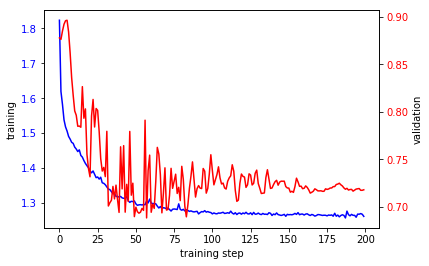

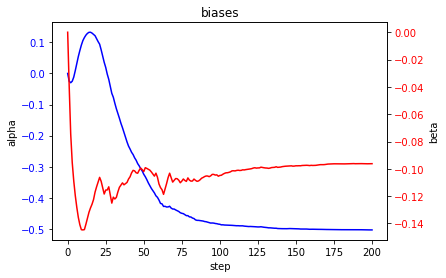

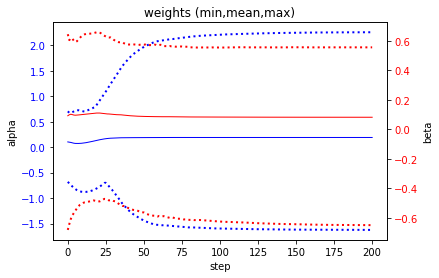

In [13]:
plot_twinaxis(x=range(len(history.history['loss'])),
              y1=history.history['loss'],
              y2=history.history['val_loss'],
              xlabel='training step',
              ylabel1='training',
              ylabel2='validation'
             )

# plt.plot(history.history['loss'],    label='training')
# plt.plot(history.history['val_loss'],label='validation')
# plt.legend()
# plt.show()
weightwatcher.plot()

## Predict 

In [14]:
# model.load_weights('./model_checkpoint.h5', by_name=False)
predicted = model.predict(x)
predicted[:,:,1]=predicted[:,:,1]+predicted[:,:,0]*0# lazy re-add of NAN-mask
print(predicted.shape)
print('mean alpha pred',np.nanmean(predicted[:,:,0]))
print('mean beta pred',np.nanmean(predicted[:,:,1]))

# Here you'd stop after transforming to dataframe and piping it back to some database
tr.padded_to_df(predicted,column_names=["alpha","beta"],dtypes=[float,float])


(1608, 885, 2)
mean alpha pred 2260.717958481447
mean beta pred 0.8018110574952609


,id,t,alpha,beta
0,0,0,109.183562,0.356526
1,0,1,85.937564,0.356277
2,0,2,73.787569,0.352827
3,0,3,10.639676,0.351828
4,0,4,8.313393,0.368351
5,0,5,5.751041,0.387278
6,0,6,5.419775,0.384943
7,0,7,6.210577,0.388499
8,0,8,8.088988,0.381246
9,0,9,14.550472,0.332610


## Scatter

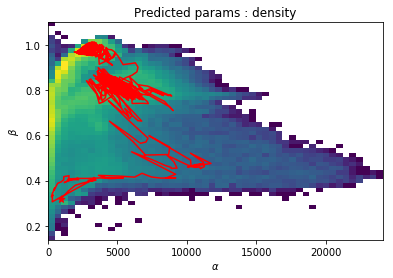

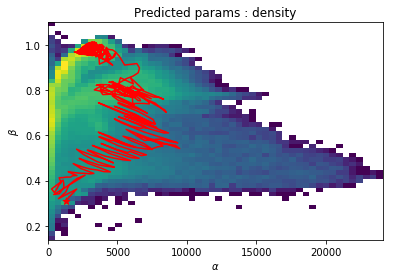

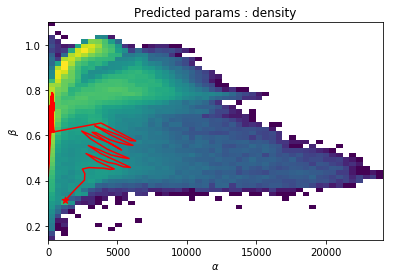

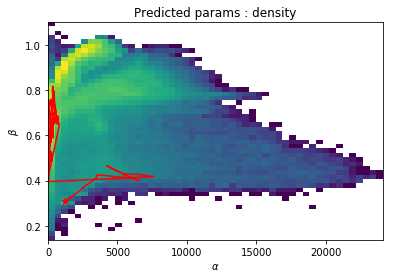

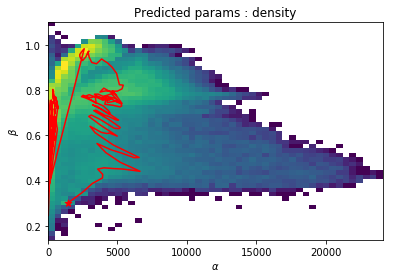

In [15]:
# Pick some random sequence
np.random.seed(9) # seed 6,9,12 interesting
random_selection =np.random.choice(predicted.shape[0], min([5,predicted.shape[0]]))
random_selection = np.sort(random_selection)

# Alpha and beta projections
mask = ~np.isnan(predicted[:,:,0])
alpha_flat = predicted[:,:,0][mask].flatten()
beta_flat  = predicted[:,:,1][mask].flatten()

## log-alpha typically makes more sense.

for batch_indx in random_selection:
    from matplotlib.colors import LogNorm
    counts, xedges, yedges, _ = plt.hist2d(alpha_flat, beta_flat, bins=50,norm=LogNorm())
    
    plt.plot(predicted[batch_indx,:,0],predicted[batch_indx,:,1],color='red')
    
    plt.scatter(predicted[batch_indx,0,0],predicted[batch_indx,0,1],
                marker = '*',
                s=50,
                color='red')
    
    plt.title('Predicted params : density')
    plt.xlim([alpha_flat.min(),alpha_flat.max()])
    plt.ylim([beta_flat.min(),beta_flat.max()])
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.show()


## Individual sequences

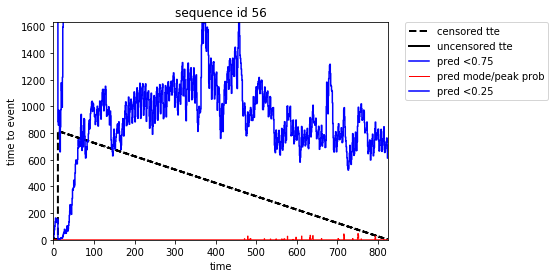

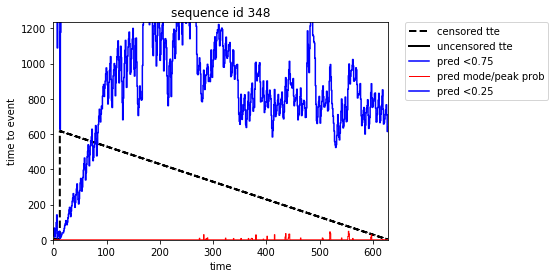

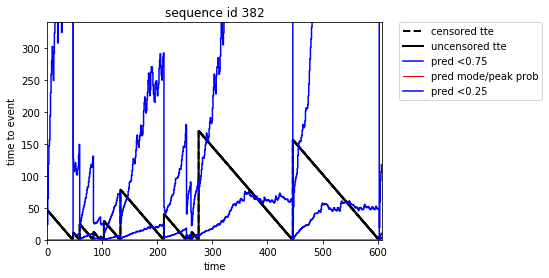

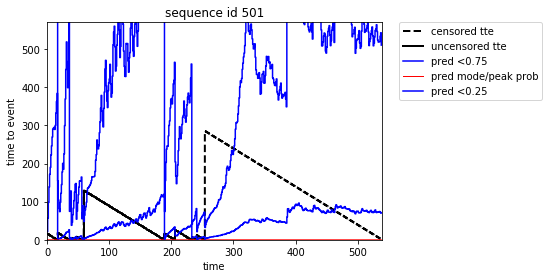

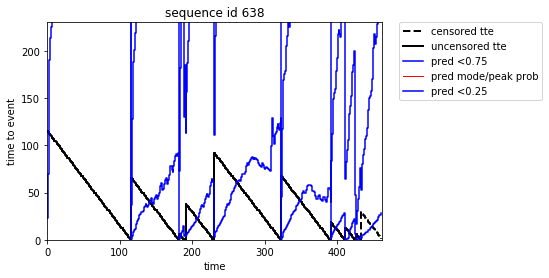

In [16]:
drawstyle = 'steps-post'
for batch_indx in random_selection:
    this_seq_len = seq_lengths[batch_indx]
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))
    x_this = x[batch_indx,:this_seq_len,:]

    this_tte = y[batch_indx,:this_seq_len,0]
    u = y[batch_indx,:this_seq_len,1]>0
    
    plt.plot(this_tte,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle=drawstyle)
    if any(u):
        plt.plot(t[u],this_tte[u],label='uncensored tte',color='black',linestyle='solid',linewidth=2,drawstyle=drawstyle)
    
    plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
    plt.plot(weibull.mode(a, b), color='red',linewidth=1,label='pred mode/peak prob',drawstyle=drawstyle)
#     plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
    plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)
    
    plt.xlim(0, this_seq_len)
    plt.ylim(0, min([2*this_tte.max(),2*a.max()]))
    plt.xlabel('time')
    plt.ylabel('time to event')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('sequence id '+str(batch_indx))
    plt.show()


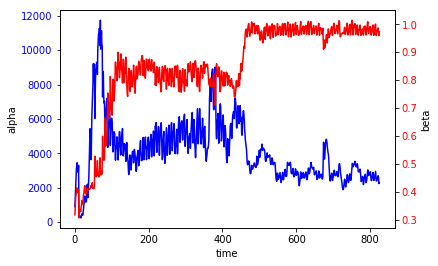

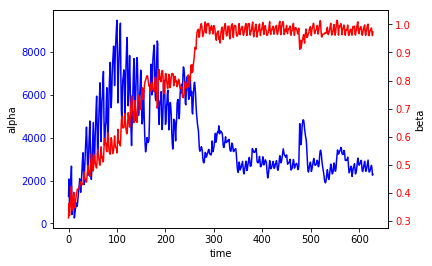

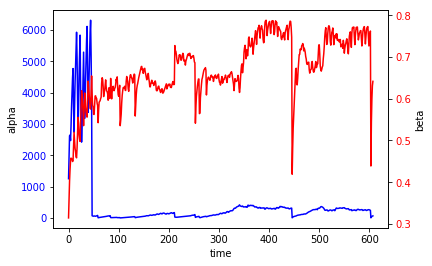

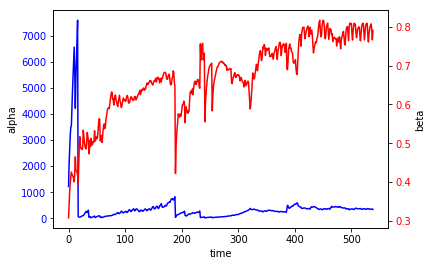

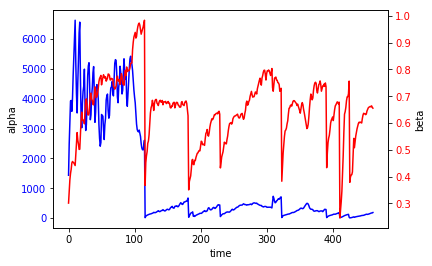

In [17]:
drawstyle = 'steps-post'
for batch_indx in random_selection:
    this_seq_len  = seq_lengths[batch_indx]
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))

    plot_twinaxis(x=t,y1=a,y2=b,xlabel='time',ylabel1='alpha',ylabel2='beta')

## Density plot 
Warning: Doesn't look impressive/anything at all when we have $\beta$ around $\leq 1$ since pdf is strictly decreasing (hence mode =0) but useful for other datasets. Predicted $\beta\leq 1$ often happens with live things as it means predicted decreasing hazard -> more time that goes since event the longer time we can expect to the next event. Also a general interpretation as exact timing of the next event is hard to predict (which is the case whenever $\beta >> 1$)

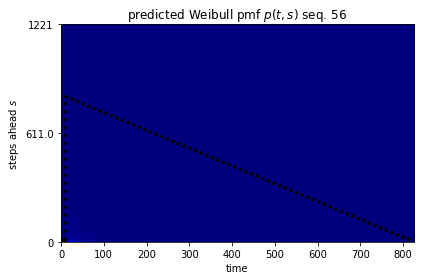

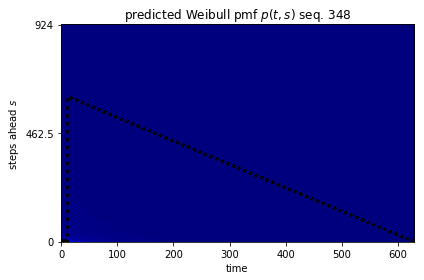

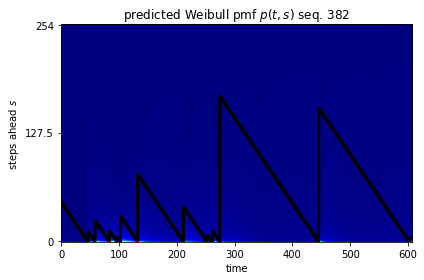

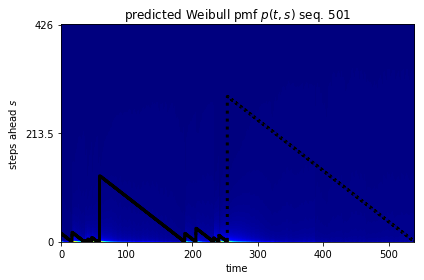

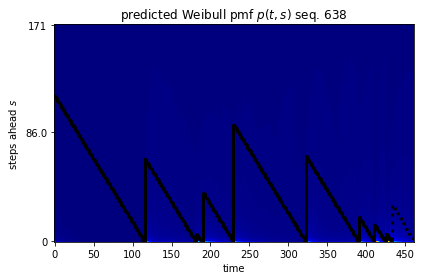

In [18]:
from wtte.plots.weibull_heatmap import weibull_heatmap
for batch_indx in random_selection:
    this_seq_len = seq_lengths[batch_indx]
    if this_seq_len==0:
        next
    a = predicted[batch_indx,:this_seq_len,0]
    b = predicted[batch_indx,:this_seq_len,1]
    t = np.array(xrange(len(a)))
    x_this = x[batch_indx,:this_seq_len,:]

    this_tte = y[batch_indx,:this_seq_len,0]
    censoring_indicator = y[batch_indx,:this_seq_len,1]<1

    fig, ax = plt.subplots(1)

    weibull_heatmap(
        fig,ax,
        t,
        a,
        b,
        max_horizon = int(1.5*this_tte.max()),
        time_to_event=this_tte,
        true_time_to_event=None,
        censoring_indicator = censoring_indicator,
        title='predicted Weibull pmf $p(t,s)$ seq. '+str(batch_indx),
        lw=3.0,
        is_discrete=True,
        resolution=None,
        xax_nbins=10,
        yax_nbins=4 
    )
    plt.show()

# Aggregate view

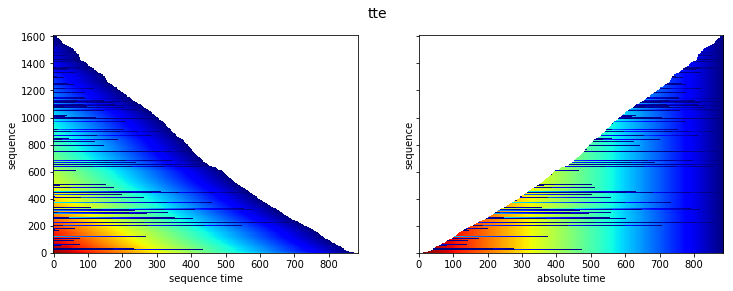

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


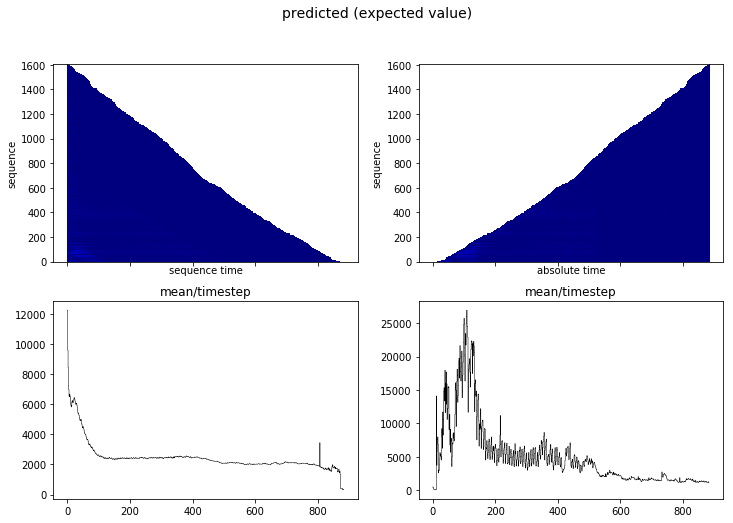

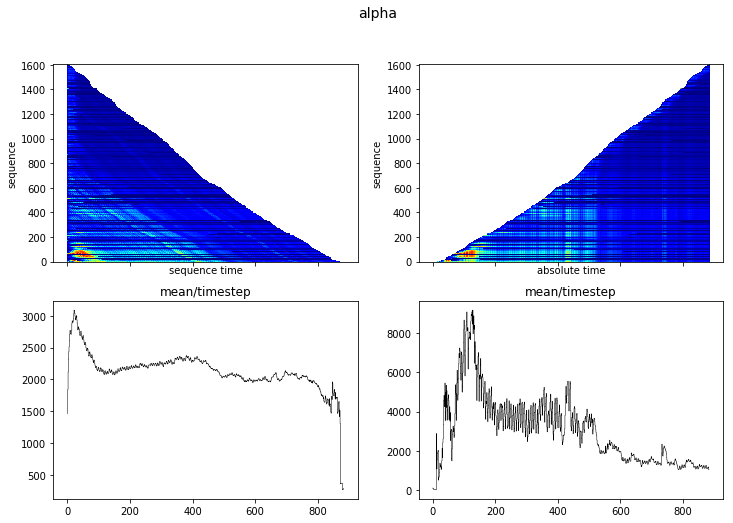

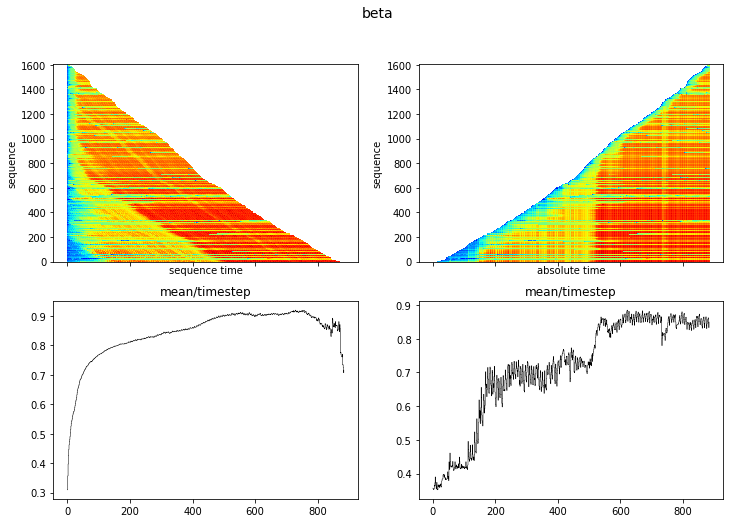

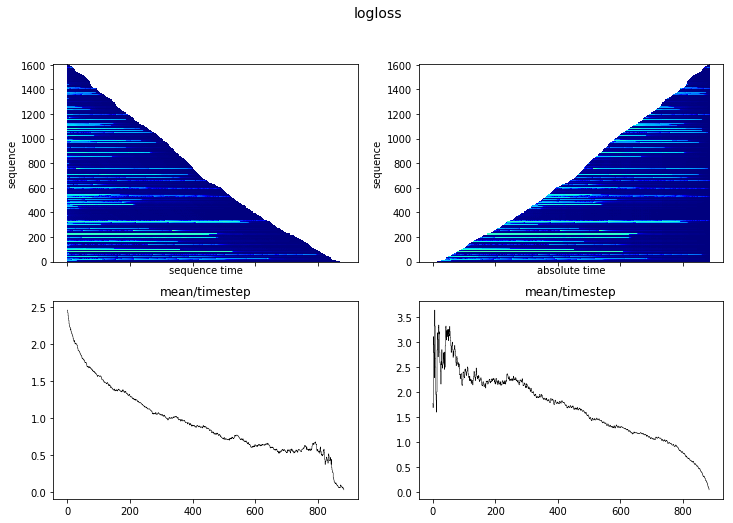

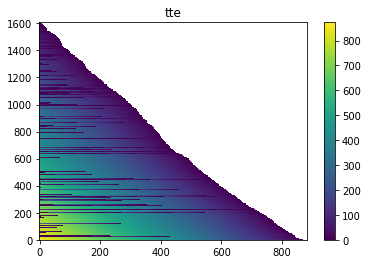

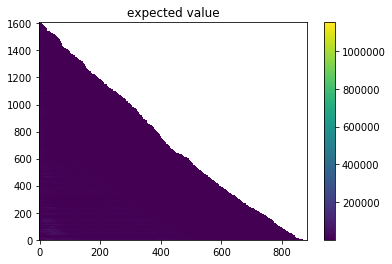

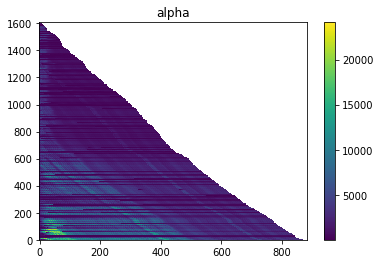

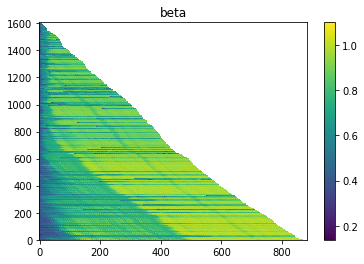

In [19]:
fig,ax = timeline_plot(y[:,:,0],"tte",plot=False)
plt.show()

padded = weibull.mean(a=predicted[:,:,0],b=predicted[:,:,1])
timeline_aggregate_plot(padded,"predicted (expected value)")
plt.show()

timeline_aggregate_plot(predicted[:,:,0],"alpha")
plt.show()

timeline_aggregate_plot(predicted[:,:,1],"beta")
plt.show()

padded = -weibull.discrete_loglik(a=predicted[:,:,0],b=predicted[:,:,1],t=y[:,:,0],u=y[:,:,1],equality=False)
timeline_aggregate_plot(padded,"logloss")
plt.show()

plt.imshow(y[:,:,0],aspect='auto',interpolation="none",origin='lower')  
plt.title('tte')
plt.colorbar()
plt.show()

padded = weibull.mean(a=predicted[:,:,0],b=predicted[:,:,1])
plt.imshow(padded,aspect='auto',interpolation="none",origin='lower')  
plt.title('expected value')
plt.colorbar()
plt.show()

plt.imshow(predicted[:,:,0],aspect='auto',interpolation="none",origin='lower')  
plt.title('alpha')
plt.colorbar()
plt.show()
plt.imshow(predicted[:,:,1],aspect='auto',interpolation="none",origin='lower')  
plt.title('beta')
plt.colorbar()
plt.show()

# Performance: Calibration & Discrimination

# Evaluated like a sliding box 

Given that we seldom have the truth due to censored data we partly need to rely on the log-loss. Calibration gives us a hint too. A more intuitive feel is to see what the AUC would have been if it was evaluated as a prediction of whether theres an event within a fixed-window. See 'sliding box' https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/#sliding-box-model

*Note* this is dependent on constant sample_weights. Weighted measure TODO

* [Brier Score](https://en.wikipedia.org/wiki/Brier_score) is the MSE of probability vs actual. A measure of calibration.
* Evaluation setting below: Think train on data until a certain date (with target censored at that point), then evaluate using the data after that point. It's also interesting to see if the training set has calibrated tte-prediction, once we evaluate using less censored data (as more timesteps are revealed)
* In real world we *only* care about the evaluation 1 step after training set ends as one typically retrains model every day but here we use more timesteps
* Brier score = 0 -> perfectly calibrated probabilities, 1 -> perfectly wrong
* AUC 0.5 -> not better than random, AUC = 1 -> perfect separation, AUC =0 -> perfect inverse separation
* Early stopping typically improves calibration (brier) while hurting discrimination (AUC)

 sliding box width 0 auc:  0.9821311122836781  brier:  0.012637117469874897 ( 44885  obs)
 sliding box width 10 auc:  0.9834067909657778  brier:  0.02270478244412503 ( 44860  obs)
 sliding box width 20 auc:  0.981909804424483  brier:  0.026017767886545126 ( 44790  obs)
 sliding box width 30 auc:  0.9789749688192224  brier:  0.028939899475556478 ( 44674  obs)
 sliding box width 40 auc:  0.9771207727479163  brier:  0.030441591520019715 ( 44486  obs)
 sliding box width 50 auc:  0.9738537464182474  brier:  0.03205966906592992 ( 44091  obs)
 sliding box width 60 auc:  0.969240098201027  brier:  0.03384292559024982 ( 43565  obs)
 sliding box width 70 auc:  0.9648177812863834  brier:  0.03620259242611173 ( 42902  obs)
 sliding box width 80 auc:  0.9605117674269879  brier:  0.038419601168820997 ( 42105  obs)
 sliding box width 90 auc:  0.9561723766590029  brier:  0.040081678344519873 ( 41137  obs)
 sliding box width 100 auc:  0.9514725076754533  brier:  0.04169625531272783 ( 40055  obs)
 slidi

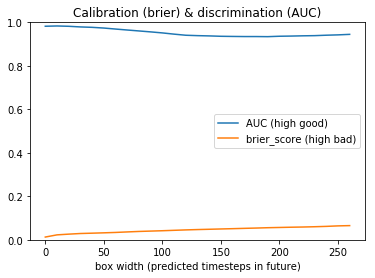

In [20]:
from sklearn import metrics
aucs =[]
brier_scores =[]
box_widths =[]

# Evaluate on timesteps after training set end.
n_timesteps = y.shape[1]# ==seq_lengths.max()
trainset_end = y_train.shape[1]# ==seq_lengths_train.max()
# We can use a box-width 0,...,n_timesteps-trainset_end
max_box_width = n_timesteps-trainset_end

# 
predicted_tmp = tr.right_pad_to_left_pad(predicted)
tte_tmp = tr.right_pad_to_left_pad(y[...,0])

for box_width in xrange(max_box_width):
    if (box_width%10)==0:
## Uncomment to visualize selection
#         plt.imshow(0*tte_tmp+(tte_tmp==0),aspect='auto',interpolation="none",origin='lower',cmap='Greys')  
#         plt.axvline(x=trainset_end,label='select begin')
#         plt.axvline(x=n_timesteps-box_width,label='select end')
#         plt.legend()
#         plt.show()

        # Select datapoints until box_width timesteps before end of test-dataset
        alpha      = predicted[:,trainset_end:(n_timesteps-box_width),0]
        beta       = predicted[:,trainset_end:(n_timesteps-box_width),1]
        tte        = tte_tmp[:,trainset_end:(n_timesteps-box_width)]
        m = ~np.isnan(tte+alpha+beta) # nan-mask
        if m.sum()==0:
            break
        is_in_box = (tte<=box_width)[m].flatten()
        pred_prob_in_box   = weibull.cmf(a=alpha,b=beta,t=box_width)[m].flatten()
        
        brier_score = np.mean((pred_prob_in_box-is_in_box)**2)
        fpr,tpr,thresholds = metrics.roc_curve(is_in_box,pred_prob_in_box)
        auc = metrics.auc(fpr,tpr)
        print(' sliding box width',box_width,'auc: ',auc,' brier: ',brier_score, '(',m.sum(),' obs)')
        aucs.append(auc)
        brier_scores.append(brier_score)
        box_widths.append(box_width)
        
plt.plot(box_widths,aucs,label='AUC (high good)')
plt.plot(box_widths,brier_scores,label ='brier_score (high bad)')
plt.ylim(0,1)
plt.legend()
plt.xlabel('box width (predicted timesteps in future)')
plt.title('Calibration (brier) & discrimination (AUC)')
plt.show()

# Esoteric plots

## Animate predicted churn
Those with alpha higher than at the their last step is red. Red stream of blood going to the right corner are predicted churners

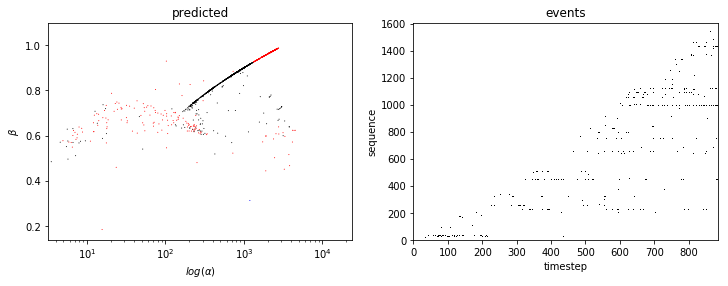

In [21]:
#### Walk through the timeline and look at the embedding.
# by day
padded = tr.right_pad_to_left_pad(predicted)
events_tmp = tr.right_pad_to_left_pad(events)
# by day since signup
# padded = np.copy(predicted)                            
# events_tmp = np.copy(events)
    
fig, ax = plt.subplots(ncols=2, sharey=False,figsize=(12,4))
cmap = None

ax[1].imshow(events_tmp,interpolation='none', aspect='auto',cmap='Greys',origin='lower')
ax[1].set_title('events');
ax[1].set_ylabel('sequence');
ax[1].set_xlabel('timestep');
ln= ax[1].axvline(x=0,c="red",linewidth=.5,zorder=10)


xlims = [np.nanmin(padded[:,:,0]),np.nanmax(padded[:,:,0])]
ylims = [np.nanmin(padded[:,:,1]),np.nanmax(padded[:,:,1])]
seq_timestep = np.cumsum(np.isnan(padded[:,:,0]),1)

for timestep in xrange(0,predicted.shape[1]):        
    ax[0].cla()

#     from matplotlib.colors import LogNorm
#     m = ~np.isnan(padded[:,timestep,0])
#     ax[0].hist2d(np.log(padded[m,timestep,0]), padded[m,timestep,1], bins=50,norm=LogNorm())
        
    if timestep == 0:
        colors = 'blue'
        this_pred = padded[:,0,:]
    else:
        m = ~np.isnan(padded[:,timestep,0])
        this_pred = padded[m,timestep,:]
    
        alpha_larger = padded[m,timestep-1,0]<padded[m,timestep,0]
        
        # blue : first step
        # Black : same or lower alpha
        # Red : higher alpha
        colors = np.repeat('black',len(alpha_larger))
        colors[alpha_larger] = 'red'
        colors[np.isnan(padded[m,timestep-1,0])] = 'blue'
    
    ax[0].scatter(this_pred[:,0],
                  this_pred[:,1],
                color = colors,
                s=1,
                linewidths=0
               )
    
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_xscale("log", nonposx='clip')
    
    ax[0].set_title('predicted');
    ax[0].set_xlabel(r'$log(\alpha)$')
    ax[0].set_ylabel(r'$\beta$')

    ln.remove()
    ln= ax[1].axvline(x=timestep,c="red",linewidth=.5,zorder=10)

#     fig_name = './figures/'+format(timestep,'05d')
#     fig.savefig(fig_name,bbox_inches='tight',transparent=False,dpi=100)
#     plt.gcf()
    display.display(plt.gcf())
    display.clear_output(wait=True)

del seq_timestep,xlims,ylims,events_tmp

# Conclusions
- 20% of the observations are censored, this is alot causing some instability.
- The network becomes fairly good at recognizing death (hence shifting the distribution up when its apparent they'r not coming back). This is partly a form of artifact learning, partly a good thing.
- Many have been puzzled why its a reverse jigsaw-pattern in the prediction (while tte/target is actually going down). As it longer time passes from an event, the more likely it is that the user is dead hence the alpha goes up. I.e the model learned a reasonable heuristic.

## Remedies for predicted tte = infinity
- I have tested some things based on Inverse Probability Of Censoring that works to keep the distribution at bay like weighting censored observations according to the probability that they'd be censored in the first place (estimated using by overfitting an identical binary network).
- Long sequences have more timesteps so more influence on loss if we dont apply weights
- Clipping. Duct-tape solution that only partly works and may risk 
- Penalizing high predictions for censored datapoints. I.e add a F(Y) penalty whenever F(Y)>some threshold and Y>some threshold
- Don't use remedies. The fact that some observations have expected values going to infinity may be what we want: to predict *churn*.
